In [1]:
import sys
import os 
import fnmatch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import axes 
from scipy.optimize import curve_fit 
from scipy.stats import norm
import numpy as np
current_directory = os.getcwd()
data_directory = current_directory+"\\extracted_data\\"
import pandas as pd
import uproot
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
sys.path.insert(1, r'C:\Users\Pascal\Desktop\TP4a\git_final_final\ecal_reco\utils')
sys.path.insert(1, r'C:\Users\Pascal\Desktop\TP4a\git_final_final\ecal_reco\tracking')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
from parameters import *
from tqdm import tqdm
from track_reconstruction import plot_hits
from physics import dist_line_rect
import pickle
from IPython import display
from time_correction import *
# from find_muon_decay import find_muon_decay
import random
from statistics import mean 

In [2]:
# Create the tracks form the raw datas and the indices events selected previously with data_creation_time
import copy

run ='run_000011'
data_storage = current_directory+"\\extracted_data\\"
raw_data_directory = "C:\\Users\\Pascal\\Desktop\\TP4a\\data\\"
df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\") #warning, the df_hits is a list of events, not of hits !
good_candidates = np.loadtxt(data_storage+"events_indices_"+run+".txt") #load the indices of the events selected as good candidates

#Now we will extract the hits of each events and create tracks for each of them

%matplotlib inline
tracks = []
uncorrected_tracks = []
fiber_corrected_tracks = []
for i in range(len(good_candidates)) :
    event = df_hits.loc[good_candidates[i]] #select the event i among the good candidates
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,j) for j in range(event['n_hits' ])] #create an array "hits" with the hits of the event i (iteration on j inside the event)
    # print (hits)    
    tempTrack = Track3D(hits) #creation of a track with the hits of the event i
    uncorrected_tracks.append(copy.deepcopy(tempTrack))
    fiber_corrected_tracks.append(copy.deepcopy(time_correction_fiber(tempTrack)))
    tracks.append(time_correction_electronics(tempTrack)) # add the track i to the tracks array witg geomertical time correction
    # print(track)

C:\Users\Pascal\Desktop\TP4a\data\run_000011\data_0000.root
selected 74.91% of all events


In [60]:
import copy
i_random = random.randint(0, len(good_candidates))
event = df_hits.loc[good_candidates[i]] #select the event i among the good candidates
hits = [Hit(event,j) for j in range(event['n_hits' ])] #create an array "hits" with the hits of the event i (iteration on j inside the event)
    # print (hits)    

uncorrected_track = Track3D(hits) #creation of a track with the hits of the event i
test = tracks[0]
#time_correction_fiber(test)
print(uncorrected_tracks[0].x.hits[0].timestamp-test.x.hits[0].timestamp)





0.2855177490022156


In [96]:
with open('uncorrected_tracks_run11.pkl','wb') as file :
    pickle.dump(uncorrected_tracks, file)
with open('fiber_corrected_tracks_run11.pkl','wb') as file :
    pickle.dump(fiber_corrected_tracks, file)
with open('tracks_run11.pkl','wb') as file :
    pickle.dump(tracks, file)
with open('muXF.pkl','wb') as file :
    pickle.dump(muXF, file)
with open('muYF.pkl','wb') as file :
    pickle.dump(muYF, file)

In [54]:
countX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muXF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

countY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muYF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

iterations = 3

for it in range(iterations):
    for i in range(24):
        for j in range(8):
            time = []
            for t in tracks:
                for hx in t.x.hits:
                    if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
                        countX[i][j] += 1
                        tbar = hx.timestamp
                        for hxp in t.x.hits:
                            if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                                time.append(hxp.timestamp-tbar-muXF[i][j]-muXF[hxp.coord[0]-1][hxp.coord[1]-1])
            muX[i][j], sigmaX[i][j] = norm.fit(time)
            time = []
            for t in tracks:
                for hy in t.y.hits:
                    if hy.coord[0]-1 == i and hy.coord[1]-1 == j: # if its the ith jth bar in x
                        countY[i][j] += 1
                        tbar = hy.timestamp
                        for hyp in t.y.hits:
                            if(not(hyp.coord[0]-1 == i and hyp.coord[1]-1 == j and not(hyp.is_sidex))):
                                time.append(hyp.timestamp-tbar-muYF[i][j]-muYF[hyp.coord[0]-1][hyp.coord[1]-1])
            muY[i][j], sigmaY[i][j] = norm.fit(time)
muXF = muXF + muX
muYF = muYF + muY

15 5


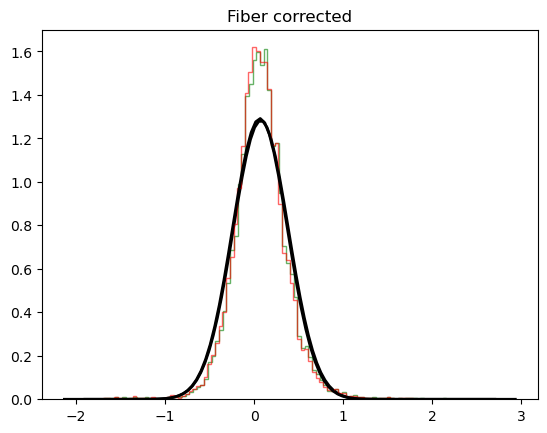

In [95]:
i = random.randint(0,23)
j = random.randint(0,7)
time = []

time = []
for t in uncorrected_tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            countX[i][j] += 1
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp-tbar)
muX[i][j], sigmaX[i][j] = norm.fit(time)

plt.figure()
plt.hist(time, bins=100, density=True, alpha=0.6, color='g', histtype='step')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
smu, ssigma = norm.fit(time)
p = norm.pdf(x, smu, ssigma )
plt.plot(x, p, 'k', linewidth=2)
plt.title("Uncorrected")
plt.grid()

for t in fiber_corrected_tracks:
    for hx in t.x.hits:
        if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
            countX[i][j] += 1
            tbar = hx.timestamp
            for hxp in t.x.hits:
                if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                    time.append(hxp.timestamp-tbar)
muX[i][j], sigmaX[i][j] = norm.fit(time)

plt.hist(time, bins=100, density=True, alpha=0.6, color='r', histtype='step')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
smu, ssigma = norm.fit(time)
p = norm.pdf(x, smu, ssigma )
plt.plot(x, p, 'k', linewidth=2)
plt.title("Fiber corrected")
plt.grid()




print(i,j)


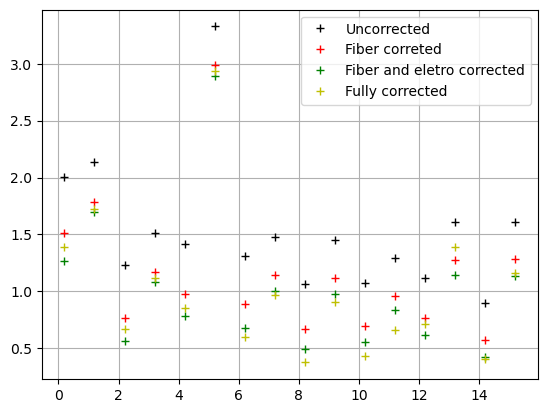

In [82]:
tracknumber = random.randint(0,len(tracks))
stamps = []
uncorrstamps = []
fiberstamps = []
corrstamps = []
heights = []
for h in uncorrected_tracks[tracknumber].x.hits + uncorrected_tracks[tracknumber].y.hits:
    uncorrstamps.append(h.timestamp)
    heights.append(h.get_pos()[1])
for h in fiber_corrected_tracks[tracknumber].x.hits + fiber_corrected_tracks[tracknumber].y.hits:
    fiberstamps.append(h.timestamp)
for h in tracks[tracknumber].x.hits + tracks[tracknumber].y.hits:
    if h.is_sidex:
        stamps.append(h.timestamp - muXF[h.coord[0]-1][h.coord[1]-1])
        corrstamps.append(h.timestamp)
    else:
        stamps.append(h.timestamp - muYF[h.coord[0]-1][h.coord[1]-1])
        corrstamps.append(h.timestamp)

plt.figure()
plt.plot(heights, uncorrstamps, "k+")
plt.plot(heights,fiberstamps,"r+")
plt.plot(heights,corrstamps, 'g+')
plt.plot(heights,stamps, 'y+')
plt.legend(["Uncorrected", "Fiber correted", "Fiber and eletro corrected", "Fully corrected"])
plt.grid()

In [91]:
from track import Track
from time_correction import*
Hx=[]
Hy=[]
for number_hits in range(8):
    Hx.append(Hit([number_hits,8-number_hits],1,0,1000,0.0))#(coord, is_sidex, timestamp, timestamp_event, value)
    Hy.append(Hit([number_hits,8-number_hits],0,0,1000,0.0))
Tx = Track(Hx)
Ty = Track(Hy)
T = Track3D(Tx,Ty)
T.show()

T_fiber_corrected = copy.deepcopy(T)
T_electronic_corrected = copy.deepcopy(T)
time_correction_fiber(T_fiber_corrected)
time_correction_electronics(T_electronic_corrected)

# recover the corrected stamps
heights = []
s_nocorr = []
s_ecorr = []
s_fibcorr = []

for h in T.x.hits + T.y.hits:
    heights.append(h.get_pos()[1])
    s_nocorr.append(h.timestamp)
for h in T_fiber_corrected.x.hits + T_fiber_corrected.y.hits:
    s_fibcorr.append(h.timestamp)
for h in T_electronic_corrected.x.hits + T_electronic_corrected.y.hits:
    s_ecorr.append(h.timestamp)

plt.figure()
plt.plot(heights,s_nocorr,'ko')
plt.plot(heights,s_ecorr, 'r+')
plt.plot(heights,s_fibcorr,'gx')
plt.grid()
plt.xlabel("Height [cm]")
plt.ylabel("Timestamp [cs]")
plt.legend(["No correction","Electronics corrected","Fiber corrected"])


timestamp x1 after correction = -0.013495806077766242
timestamp x2 after correction = -0.022442973788854535
timestamp y after correction = -0.008462962962963155
